In [90]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [91]:
X = pd.read_csv("breast_cancer.csv")

In [92]:
X.shape

(699, 12)

In [93]:
X.columns

Index([u'Unnamed: 0', u'id number', u'clump_thickness',
       u'uniformity_of_cell_size', u'uniformity_of_cell_shape',
       u'marginal_adhesion', u'epithelial_cell_size', u'bare_nuclei',
       u'bland_chromatin', u'normal_nucleoli', u'mitoses', u'malignant'],
      dtype='object')

In [94]:
X.head(1)

,Unnamed: 0,id number,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,0,1000025,5,1,1,1,2,1,3,1,1,0


In [95]:
X=X.drop(["Unnamed: 0", "id number"],axis =1)

In [96]:
X.head(1)

,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,5,1,1,1,2,1,3,1,1,0


In [97]:
X.shape

(699, 10)

In [98]:
X.size

6990

In [99]:
#Setting malignant as the output feature 
y = X.pop("malignant")

In [100]:
X.head(1)

,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
0,5,1,1,1,2,1,3,1,1


In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

<h4>Grid Search</h4>

In [102]:
### Grid Search
n_estimators = [300,400,500]
max_features = ['auto', 'sqrt','log2']
min_samples_split = [3,5,7]

rfc = RandomForestClassifier(n_jobs=1)
#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split
                              ), cv=None, n_jobs=-1)

In [103]:
estimator.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [3, 5, 7], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [104]:
estimator.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [105]:
best_rfc = estimator.best_estimator_

<h4>Measure Accuracy</h4>

In [106]:
accuracy = accuracy_score(y_test, best_rfc.predict(X_test))
print "Accuracy: ", accuracy

Accuracy:  0.964285714286


<h4>Precision and Recall</h4>

In [107]:
print classification_report(y_test, best_rfc.predict(X_test))

             precision    recall  f1-score   support

          0       0.97      0.98      0.97        95
          1       0.95      0.93      0.94        45

avg / total       0.96      0.96      0.96       140



In [108]:
print confusion_matrix(y_test, best_rfc.predict(X_test))

[[93  2]
 [ 3 42]]


<h6>Precision:</h6>  42 / 42 + 2 = .95 (tp / tp+fp)
<h6>Recall:</h6>   42 / 42 + 3 = .93 (tp / tp + fn)

<h4>AUC score</h4>

In [109]:
roc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:,1])
print "AUC Score: ", roc

AUC Score:  0.995789473684


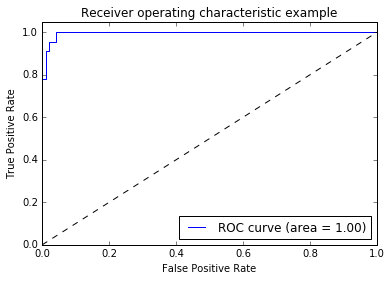

In [110]:
fpr, tpr, thresholds = roc_curve(y_test, best_rfc.predict_proba(X_test)[:,1])
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<h4>K-Fold Cross Validation</h4>

In [111]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(best_rfc, X, y, cv=10)

In [112]:
scores

array([ 0.91549296,  0.98571429,  0.97142857,  0.91428571,  0.98571429,
        0.97142857,  0.98571429,  0.98571429,  0.98550725,  1.        ])

In [113]:
mean_score = scores.mean()
std_dev = scores.std()
std_error = scores.std() / math.sqrt(scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Score is %f +/-  %f" % (mean_score, ci)
print '95 pct chance that if this experiment were repeated over and over, the avg. score would be between %f and %f' % (lower_bound, upper_bound)

Score is 0.970100 +/-  0.020492
95 pct chance that if this experiment were repeated over and over, the avg. score would be between 0.949608 and 0.990592


<h4>Description of Model Performance</h4>

K-Fold CV Score: 95% chance for the score to be within 0.95 - 0.99
Single holdout AUC: 0.996
As can be seen from the scores above, the Single holdout AUC fares better in terms of exactness.

The model would correctly identify 95% of malignancy (i.e. 5% chance that a benign/non-existent case gets reported as malignant), as obtained from the Precision of the model.

Of the total malignant cases identified, 93% would actually be malignant, as obtained from the Recall of the model.

Test Accuracy of the model = 0.94 as derived from the f1-score that balances the precision and recall.